In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext rpy2.ipython

In [2]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data/NARPS_MG_asc_processed"
pupil_data = []

for file in os.listdir(dir):
    if file.endswith("timeseries_start.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        pupil_data.append(csv)

pupil_data = pd.concat(pupil_data)

In [4]:
pupil_data["sub_trial"] = pupil_data["sub"].astype(str) + "_" + pupil_data["trial"].astype(str)
# find sub_trial with nan values in ps_preprocessed
# These are the trials in the beginning of the runs. 
nan_sub_trial = pupil_data[pupil_data["ps_preprocessed"].isna()]["sub_trial"].unique()
# remove sub_trial with nan values in ps_preprocessed
pupil_data = pupil_data[~pupil_data["sub_trial"].isin(nan_sub_trial)]

In [5]:
# replace all nan in outofbounds with 0
pupil_data["outofbounds"] = pupil_data["outofbounds"].fillna(0)

In [6]:
behav = pd.read_csv("../../data/behavioral_data.csv")

In [7]:
# Merge behav and pupil_data
data = pupil_data.merge(behav, on=["sub", "trial"])
# remove RT < 0.2 and response_int.isna()
data = data.query("RT > 0.2 & response_int.notna()")

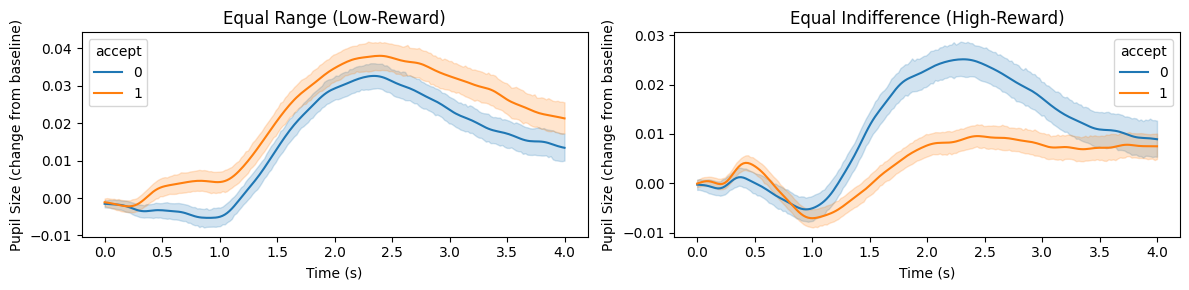

In [8]:
# Create subplot with 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Equal Range plot
sns.lineplot(data=data.query("condition == 'equalRange'"), 
            x='timebin', y='ps_preprocessed', hue='accept', ax=ax1)
ax1.set_title('Equal Range (Low-Reward)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pupil Size (change from baseline)')

# Equal Indifference plot  
sns.lineplot(data=data.query("condition == 'equalIndifference'"), 
            x='timebin', y='ps_preprocessed', hue='accept', ax=ax2)
ax2.set_title('Equal Indifference (High-Reward)') 
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pupil Size (change from baseline)')

plt.tight_layout()
plt.show()


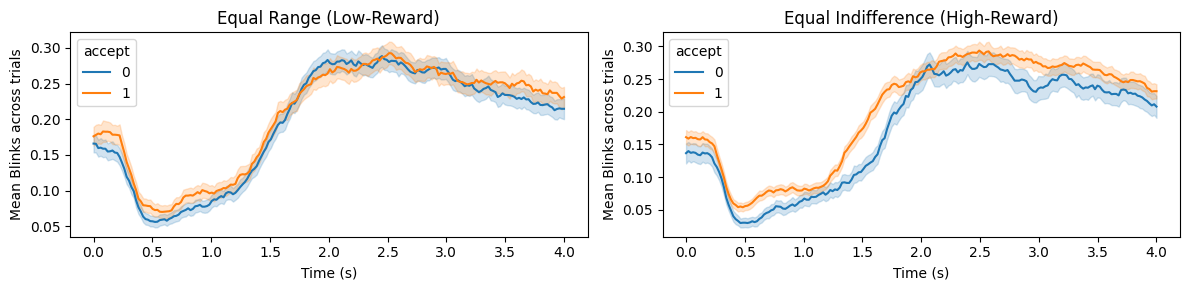

In [9]:
# Create subplot with 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Equal Range plot
sns.lineplot(data=data.query("condition == 'equalRange'"), 
            x='timebin', y='blink', hue='accept', ax=ax1)
ax1.set_title('Equal Range (Low-Reward)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Mean Blinks across trials')

# Equal Indifference plot  
sns.lineplot(data=data.query("condition == 'equalIndifference'"), 
            x='timebin', y='blink', hue='accept', ax=ax2)
ax2.set_title('Equal Indifference (High-Reward)') 
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Mean Blinks across trials')

plt.tight_layout()
plt.show()

In [10]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "outofbounds". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'bool'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [11]:
%%R
# loop through timebins
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
    model = lmer(ps_preprocessed ~ accept*condition + blink*condition + (1|sub), data=data[data$timebin == tb, ])
    # save the coefficients and pvalues in a list
    fixed_effects <- summary(model)$coefficients
    # Loop through fixed effects
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
    }
}

In [12]:
%%R
# put them into a dataframe
coefficient_df <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues)

In [13]:
%%R -o coefficient_df
str(coefficient_df)

'data.frame':	1200 obs. of  4 variables:
 $ timebin : num  0 0 0 0 0 ...
 $ name    : chr  "(Intercept)" "accept" "conditionequalRange" "blinkTRUE" ...
 $ estimate: num  -0.000484 0.000138 -0.001395 0.001819 0.000402 ...
 $ pvalue  : num  0.4709 0.8512 0.114 0.0547 0.6946 ...


In [14]:
accept_LR = coefficient_df.query("name == 'accept'")['estimate'].values + coefficient_df.query("name == 'accept:conditionequalRange'")['estimate'].values
accept_HR = coefficient_df.query("name == 'accept'")['estimate'].values
timebins = coefficient_df.query("name == 'accept'")['timebin'].values

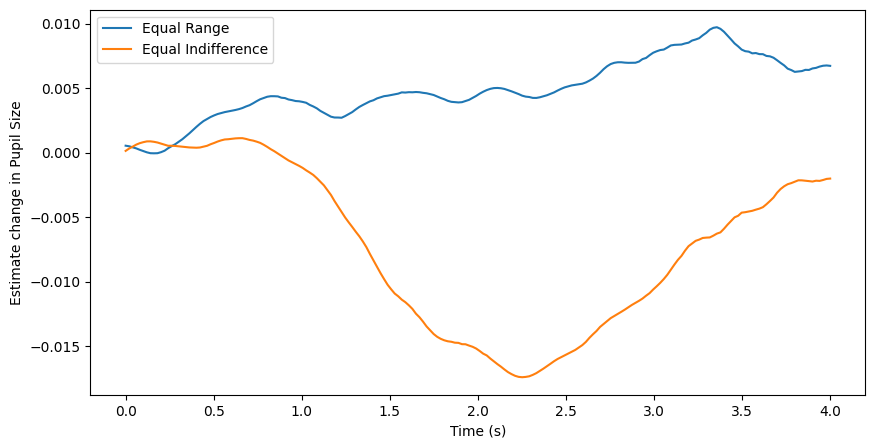

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(timebins, accept_LR, label='Equal Range')
ax.plot(timebins, accept_HR, label='Equal Indifference')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Estimate change in Pupil Size')
plt.show()


In [16]:
accept_LR_pvalue = coefficient_df.query("name == 'accept:conditionequalRange'")['pvalue'].values
accept_HR_pvalue = coefficient_df.query("name == 'accept'")['pvalue'].values
timebins = coefficient_df.query("name == 'accept'")['timebin'].values

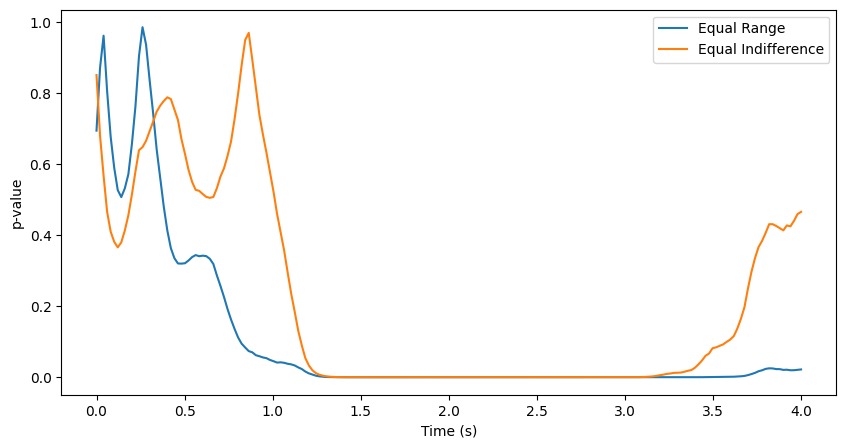

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(timebins, accept_LR_pvalue, label='Equal Range')
ax.plot(timebins, accept_HR_pvalue, label='Equal Indifference')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('p-value')
plt.show()

In [6]:
# create new column sub_trial
data['sub_trial'] = data['sub'].astype(str) + '_' + data['trial'].astype(str)

In [9]:
invalid_sub_trials = data.groupby('sub_trial')['blink'].mean().reset_index().query('blink > 0.25')["sub_trial"].unique()

In [10]:
data = data[~data['sub_trial'].isin(invalid_sub_trials)]

In [12]:
percent_removed = []
for sub in data['sub'].unique():
    # check how many sub_trials are missing
    sub_trials = data.query('sub == @sub')['sub_trial'].unique()
    percent_removed.append(1 - len(sub_trials) / 256)


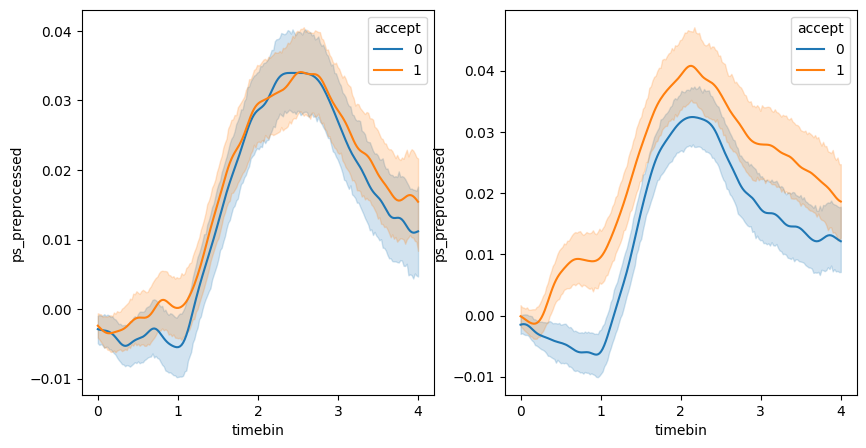

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=data.query("condition == 'equalRange' & (response_int == 2 | response_int == 3)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[0])
sns.lineplot(data=data.query("condition == 'equalRange' & (response_int == 1 | response_int == 4)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[1])

plt.show()

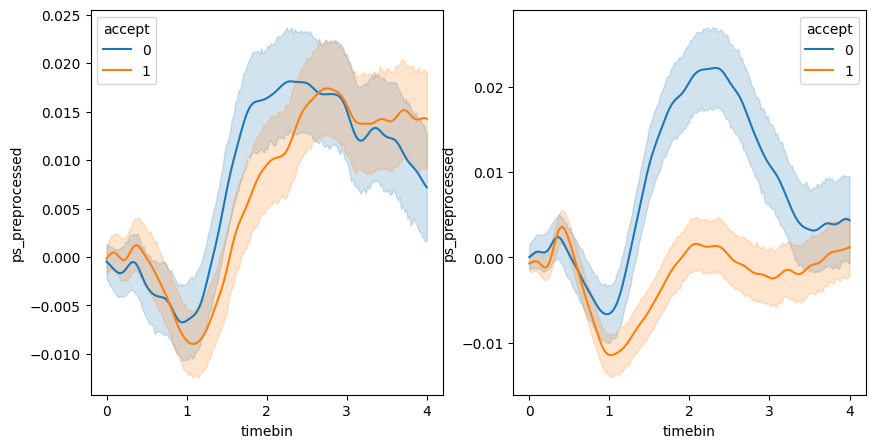

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=data.query("condition == 'equalIndifference' & (response_int == 2 | response_int == 3)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[0])
sns.lineplot(data=data.query("condition == 'equalIndifference' & (response_int == 1 | response_int == 4)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[1])

plt.show()

<Axes: xlabel='timebin', ylabel='ps_preprocessed'>

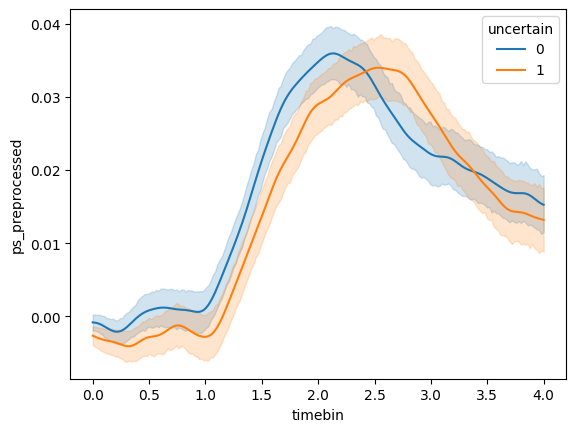

In [27]:
sns.lineplot(data=data.query("condition == 'equalRange'"), x='timebin', y='ps_preprocessed', hue='uncertain')
sns.lineplot(data=data.query("condition == 'equalRange'"), x='timebin', y='ps_preprocessed', hue='uncertain')


<Axes: xlabel='timebin', ylabel='ps_preprocessed'>

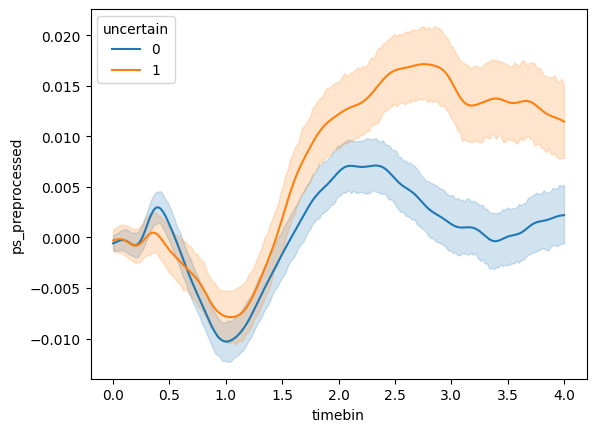

In [28]:
sns.lineplot(data=data.query("condition == 'equalIndifference'"), x='timebin', y='ps_preprocessed', hue='uncertain')
